<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_h5py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install h5py

In [2]:
""" CONFIGURE """

import h5py
import numpy as np
import os
import tempfile
import urllib
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess

response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py
trodes_dat_reader_loc = 'C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\LFP_Refactor\\Trodes_2-5-1_Windows64\\Resources\\TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



In [3]:
"""
New Python Based Pipeline for Trodes
"""
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Find APs """
""" Find IIS """


' Find IIS '

In [178]:
def plot_sample_wave(lfp,sample_rate,times=[0,3],ref=None,tics=None,fig_dim=(3,1.5)):

    colors = {0:'k',1:'r'}

    tic_indicies = np.arange(times[0]*sample_rate,times[1]*sample_rate,dtype=int)
    time_sec = tic_indicies/sample_rate
    waveform = lfp[tic_indicies,:]

    num_chan = waveform.shape[1]
    if ref is not None:
        num_chan+= 1
    fig,ax=plt.subplots(num_chan,1,figsize=fig_dim,dpi=300)
    for ch in np.arange(num_chan):
        if ch>=waveform.shape[1]:
            ax[ch].plot(time_sec,-ref[tic_indicies],linewidth=.2,color='c')
            ax[ch].text(time_sec[0],0,'ref',ha='right',va='center')
        else:
            ax[ch].plot(time_sec,waveform[:,ch],linewidth=.2,color=colors[np.mod(ch//8,2)])
            if ch%8 == 0 or ch+1==waveform.shape[1]:
                ax[ch].text(time_sec[0],0,f'ch.{int(ch+1)}',ha='right',va='center')
        ax[ch].set_position([0,ch/num_chan,1,1/num_chan])
        ax[ch].axis('off')
        if tics is not None:
            for t in tics:
                ax[ch].axhline(t,linewidth=.1 ,color='k') #
    return

In [5]:
def export_to_csv(session_hdf_file):
    dataset_name_list = list_hdf5_dataset_names(session_hdf_file)
    for dataset_name in tqdm(dataset_name_list):
        dataset = load_hdf5_to_var(session_hdf_file, dataset_name)
        if dataset.shape == ():
            df = pd.DataFrame([dataset])
        else:
            df = pd.DataFrame(dataset)
        df.to_csv(dataset_name+'.csv')


In [6]:
import pandas as pd
import h5py

def save_dataframe_to_group(hdf5_group, df, group_name, index):
    """
    Save or overwrite a single DataFrame in a group in the HDF5 file, preserving the order.

    Parameters:
    - hdf5_group (h5py.Group): The HDF5 group where the DataFrame will be stored.
    - df (pd.DataFrame): The DataFrame to save.
    - group_name (str): The name of the subgroup in the HDF5 group.
    - index (int): The index of the DataFrame in the original list to preserve order.
    """
    if group_name in hdf5_group:
        print(f"Warning: Overwriting existing group '{group_name}'.")
        del hdf5_group[group_name]

    df_group = hdf5_group.create_group(group_name)
    df_group.create_dataset('data', data=df.to_numpy())
    df_group.attrs['columns'] = df.columns.tolist()
    df_group.attrs['index'] = index  # Store the index to preserve order

def save_dataframes_to_hdf5(session_hdf_file, dataframes, group_name='ripple_dfs'):
    """
    Save a list of DataFrames to an HDF5 file under a specified group, preserving their order.

    Parameters:
    - session_hdf_file (str): The name of the HDF5 file.
    - dataframes (list of pd.DataFrame): The list of DataFrames to save.
    - group_name (str): The name of the group where DataFrames will be stored.
    """
    with h5py.File(session_hdf_file, 'a') as hdf5_file:
        if group_name in hdf5_file:
            print(f"Warning: Overwriting existing group '{group_name}' and its contents.")
            del hdf5_file[group_name]

        group = hdf5_file.create_group(group_name)

        for i, df in enumerate(dataframes):
            subgroup_name = f'rip_df_{i}'
            save_dataframe_to_group(group, df, subgroup_name, i)

    print(f"DataFrames have been saved in the HDF5 file under the '{group_name}' group.")

def load_dataframe_from_group(hdf5_group, group_name):
    """
    Load a DataFrame from a group in the HDF5 file.

    Parameters:
    - hdf5_group (h5py.Group): The HDF5 group where the DataFrame is stored.
    - group_name (str): The name of the subgroup containing the DataFrame.

    Returns:
    - df (pd.DataFrame): The loaded DataFrame.
    - index (int): The index of the DataFrame to preserve order.
    """
    df_group = hdf5_group[group_name]
    data = df_group['data'][:]
    columns = df_group.attrs['columns']
    index = df_group.attrs['index']

    df = pd.DataFrame(data, columns=columns)
    return df, index

def load_dataframes_from_hdf5(session_hdf_file, group_name='ripple_dfs'):
    """
    Load a list of DataFrames from an HDF5 file under a specified group,
    preserving their original order by pre-allocating the list.

    Parameters:
    - session_hdf_file (str): The name of the HDF5 file.
    - group_name (str): The name of the group from which to load DataFrames.

    Returns:
    - dataframes (list of pd.DataFrame): The list of loaded DataFrames, in original order.
    """
    with h5py.File(session_hdf_file, 'r') as hdf5_file:
        if group_name in hdf5_file:
            group = hdf5_file[group_name]
            # Pre-allocate the list with None values based on the number of DataFrames
            num_dataframes = len(group)
            dataframes = [None] * num_dataframes

            for subgroup_name in group.keys():
                df, index = load_dataframe_from_group(group, subgroup_name)
                dataframes[index] = df  # Place the DataFrame in the correct order

        else:
            print(f"Group '{group_name}' does not exist in the HDF5 file.")
            return []

    return dataframes


In [7]:
def axm(ch):
    return  ch%8, 3-(ch//8)

def rip_hist(ripple_df_list):
    fig,ax = plt.subplots(8,4,figsize=(3,6))
    for ch,rip_df in enumerate(ripple_df_list):
        count,edges = np.histogram(rip_df['ripple_sd_max'],bins=np.logspace(1,4,20,base=2))
        ax[axm(ch)].stairs(count/np.sum(count),edges,linewidth=.4,color='k')
    plt.tight_layout()
    return fig,ax

def plot_rip_counts(ripple_df_list,thresh_list=None):
    fig,ax = plt.subplots(figsize=(4,1.5))
    if thresh_list is None:
        thresh_list = np.arange(3,8)
    ch = np.arange(len(ripple_df_list))
    for t in thresh_list:
        ax.plot(ch, [np.sum(df['ripple_sd_max']>t) for df in ripple_df_list],label=f'{t}sd')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Ripple Count')
    _, max_y = ax.get_ylim()
    ax.set_ylim(0, max_y)
    plt.legend()

def find_starts_stops(trace,thresh):
    thresh_diff = np.diff(trace>thresh,prepend=0)
    starts = np.where(thresh_diff>0)[0]
    stops = np.where(thresh_diff<0)[0]
    if trace[-1] > thresh:
        starts = starts[:-1]
    return starts,stops



In [8]:

def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    print(f'Loading {dtype} array shape:{shape}...')
    with open(npy_filename, 'rb') as f:
        array = np.memmap(f, dtype=dtype, mode='r+', offset=offset, shape=shape)
    print('     complete.')
    return array

def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()



def update_hdf_data(file_path, dataset_name, new_data,dtype=None):
    """
    Update an existing dataset in an HDF5 file or create a new one if it doesn't exist.

    Parameters:
    - file_path (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset to update or create.
    - new_data (numpy.ndarray): Data to write into the dataset.
    """

    if new_data.shape==():
        dtype = new_data.dtype
        new_data=[new_data]

    # Open an HDF5 file in read/write mode
    with h5py.File(file_path, 'a') as hdf_file:
        # Check if dataset already exists
        if dataset_name in hdf_file:
            # Dataset exists, update its contents
            del hdf_file[dataset_name]
            hdf_file[dataset_name] = new_data
            print(f"Dataset '{dataset_name}' updated.")
        else:
            # Dataset does not exist, create a new one
            if dtype is None:
                dtype = new_data.dtype
            hdf_file.create_dataset(dataset_name, data=new_data, dtype=dtype)
            print(f"Dataset '{dataset_name}' '{dtype}' created with new data.")
        hdf_file.close()

def list_hdf5_dataset_names(file_path):
    """
    List all dataset names in an HDF5 file.

    Parameters:
    - file_path (str): Path to the HDF5 file.

    Returns:
    - list: A list containing all dataset names and their data types.
    """
    dataset_names = []

    with h5py.File(file_path, 'r') as hdf_file:
        def collect_dataset_names(name, obj):
            if isinstance(obj, h5py.Dataset):
                dataset_names.append((name, str(obj.dtype)))

        hdf_file.visititems(collect_dataset_names)

    for name, dtype in dataset_names:
        print(f"{name} {dtype}")

    return [d[0] for d in dataset_names]




def load_hdf5_to_var(hdf5_filename, dataset_name):
    """
    Load a dataset from an HDF5 file into a NumPy memmap array.

    Parameters:
    - hdf5_filename (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset within the HDF5 file.

    Returns:
    - memmap_array (numpy.memmap): Memmap array containing the dataset.
    """
    with h5py.File(hdf5_filename, 'r') as hdf_file:
        # Check if the dataset exists
        if dataset_name in hdf_file:
            dataset = hdf_file[dataset_name]
            if dataset.ndim == 0:
                # Dataset is scalar, return the single value
                data = dataset[()][0]
            else:
                # Dataset is not scalar, apply slicing if start and end are specified
                data = dataset[:][0]
            return data
        else:
            raise KeyError(f"Dataset '{dataset_name}' not found in the file.")
    print('Loading complete.')
    return data

def load_hdf5_to_memmap(hdf5_filename, dataset_name):
    """
    Load a dataset from an HDF5 file into a NumPy memmap array.

    Parameters:
    - hdf5_filename (str): Path to the HDF5 file.
    - dataset_name (str): Name of the dataset within the HDF5 file.

    Returns:
    - memmap_array (numpy.memmap): Memmap array containing the dataset.
    """

    with h5py.File(hdf5_filename, 'r') as f:
        # Read metadata from HDF5 attributes or dataset properties
        dataset = f[dataset_name]
        shape = dataset.shape
        dtype = dataset.dtype

        print(f'Loading {dtype} array shape: {shape} from HDF5...')

        if shape == ():  # Check if the dataset is scalar
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()
            # Create memmap array for a single scalar value
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=(1,))
            memmap_array[0] = float(dataset[()])
        else:
            # Create a temporary file
            temp_file = tempfile.NamedTemporaryFile(delete=False)
            temp_file.close()

            # Create memmap array and write data to it
            memmap_array = np.memmap(temp_file.name, dtype=dtype, mode='w+', shape=shape)
            memmap_array[:] = dataset[:]
        f.close()
    print('Loading complete.')
    return memmap_array, temp_file.name

def check_valid(array):
    total = np.prod(array.shape)
    nan_count = np.sum(np.isnan(array.flatten()))
    inf_count = np.sum(np.logical_not(np.isfinite(array.flatten())))
    print(f'nans:{nan_count}, infs:{inf_count} out of {total}')

In [9]:


def find_trace_ripples_df_v4(trace, downsampled_rate, min_thresh_SD=3, min_dur_ms=15, min_gap_ms=0,baseline=0):
    """
    Detects ripple events in a given trace and returns their characteristics as a DataFrame.

    Parameters:
    trace (array-like): The input signal trace in which to detect ripples.
    downsampled_rate (int): The downsampled rate of the signal in Hz.
    min_thresh_SD (float, optional): Minimum threshold for ripple detection in standard deviations (SD). Default is 3 SD.
    min_dur_ms (int, optional): Minimum duration of a ripple event in milliseconds. Default is 15 ms.
    min_gap_ms (int, optional): Minimum gap duration between consecutive ripples in milliseconds. Default is 4 ms.

    Returns:
    pd.DataFrame: A DataFrame containing the start and stop indices of ripples, the index of the maximum value within each ripple, the maximum value of the ripple in SD, and the duration of the ripple in milliseconds.
        - 'starts': Start indices of detected ripples.
        - 'stops': Stop indices of detected ripples.
        - 'max_tic': Indices of the maximum value within each detected ripple.
        - 'ripple_sd_max': Maximum values of the detected ripples in SD.
        - 'duration_ms': Duration of each ripple event in milliseconds.
    """

    # Get all positive/negative baseline crossings
    base_starts,base_stops = find_starts_stops(trace,baseline)

    # Calculate the duration of each putative ripple in milliseconds
    duration_ms = (base_stops - base_starts) / downsampled_rate * 1000

    # Convert minimum duration from milliseconds to samples
    min_dur_tics = int(min_dur_ms / 1000 * downsampled_rate)
    # Calculate the minimum gap duration in ticks (samples)
    min_gap_tics = int(min_gap_ms / 1000 * downsampled_rate)


    # Initialize arrays to store the maximum values and their indices within each ripple
    ripple_sd_max = np.ones_like(base_starts)*np.nan
    max_tic = np.ones_like(base_starts)*-1
    thresh_cross = np.ones_like(base_starts)*-1

    # Iterate over each detected ripple to find the maximum value and its index
    for rip, (tic_on, tic_off) in enumerate(zip(base_starts, base_stops)):
        rip_trace = trace[tic_on:tic_off]
        thresh_starts,thresh_stops = find_starts_stops(rip_trace,min_thresh_SD)
        if len(thresh_starts)>0:
            # print('thresh_starts',thresh_starts)
            if len(thresh_starts)>1:
                gap_dur = thresh_starts[1:] - thresh_stops[:-1]
                gaps_to_keep = gap_dur > min_gap_tics
                thresh_starts = thresh_starts[np.insert(gaps_to_keep, 0, True)]
                thresh_stops = thresh_stops[np.insert(gaps_to_keep, -1, True)]
            valid_durations = (thresh_stops - thresh_starts) >= min_dur_tics
            if np.sum(valid_durations)>0:
                max_tic[rip] = int(np.argmax(rip_trace) + tic_on)  # Adjust index to the correct position in the trace
                ripple_sd_max[rip] = trace[int(max_tic[rip])] # Use the whole trace
                thresh_cross[rip] = int(thresh_starts[0] +tic_on)


    # Create a DataFrame to store the ripple characteristics
    channel_ripples_df = pd.DataFrame({
        'starts': base_starts,
        'stops': base_stops,
        'starts_s': base_starts/downsampled_rate,
        'stops_s': base_stops/downsampled_rate,
        'max_tic': max_tic,
        'thresh_cross':thresh_cross,
        'ripple_sd_max': ripple_sd_max,
        'duration_ms': duration_ms
    })
    channel_ripples_df = channel_ripples_df[channel_ripples_df['ripple_sd_max']>=min_thresh_SD]
    channel_ripples_df = channel_ripples_df[np.logical_not(np.isnan(channel_ripples_df['ripple_sd_max']))]
    channel_ripples_df = channel_ripples_df.reset_index(drop=True)
    return channel_ripples_df


In [10]:
""" Session Info """
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'\\hive\Huang-LFP\TabuenaLFP\SpikeGadgets\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive\Huang-LFP\TabuenaLFP\ZL04_6201\ZL04_6201.rec'
animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'
session_hdf_file=os.path.join(my_analysis_dir,animal_session+'.hdf5')


In [ ]:
session_hdf_file

In [11]:
# list_hdf5_dataset_names(session_hdf_file)

In [12]:
# """
# Generate RAW_LFP Binaries from *.rec files
# eta 20m
# """
# output_directory = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA_252'
# os.chdir(my_analysis_dir)
# full_cmd_raw = ' '.join([export_func_location, '-raw',
#                     '-rec ', dot_rec_file_loc,
#                     '-userawrefs', str(0),
#                     '-outputdirectory', output_directory])
# export_report = subprocess.run(full_cmd_raw)
dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA_252\ZL04_6201.raw\ZL04_6201.raw_group0.dat'


"""
Import RAW_LFP
eta 10m
"""
print(dot_dat_file_loc)
dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])
default_sample_rate = np.float64(dot_dat_data['clockrate'])
num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]
memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
lfp_disk_array = dot_dat_data['data']['voltage'].astype('float16')
check_valid(lfp_disk_array)
lfp_disk_array*=voltage_scaling
update_hdf_data(session_hdf_file, 'raw_lfp', lfp_disk_array)
update_hdf_data(session_hdf_file, 'default_sample_rate', default_sample_rate)
print(f'{lfp_disk_array.shape[0]/30000/60} minutes')

\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA_252\ZL04_6201.raw\ZL04_6201.raw_group0.dat
nans:0, infs:0 out of -825413632
Dataset 'raw_lfp' updated.
Dataset 'default_sample_rate' updated.
60.235306666666666 minutes


Loading float16 array shape: (108423552, 32) from HDF5...
Loading complete.
Dataset 'downsampled_rate' updated.
Dataset 'downsampled_lfp' updated.


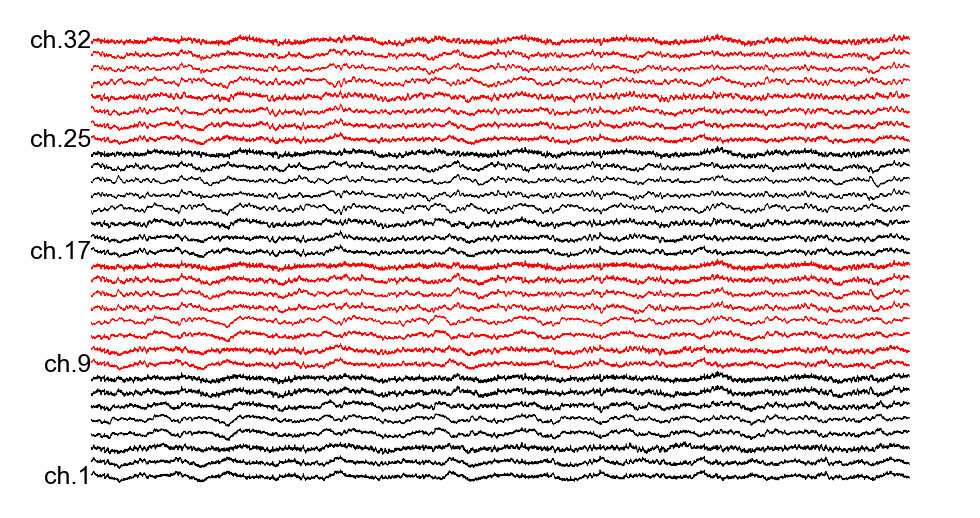

In [13]:
"""
DOWNSAMPLE & SAVE
eta 1m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'raw_lfp')
default_sample_rate = load_hdf5_to_var(session_hdf_file, 'default_sample_rate')
downsampled_rate = np.array(5000)
update_hdf_data(session_hdf_file, 'downsampled_rate', downsampled_rate)

downsample_factor = int(default_sample_rate/downsampled_rate)
lfp_disk_array=lfp_disk_array[1::downsample_factor,:]
# ref = np.expand_dims(np.mean(lfp_disk_array,axis=1),axis=-1)
# ref = np.zeros_like(ref)
# lfp_disk_array -= ref
# update_hdf_data(session_hdf_file, 'ref_trace', ref)
update_hdf_data(session_hdf_file, 'downsampled_lfp', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate) # ,ref=ref

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)


Loading float16 array shape: (108423552, 32) from HDF5...
Loading complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:35<00:00,  4.87s/it]


Dataset 'spikeband_lfp' updated.


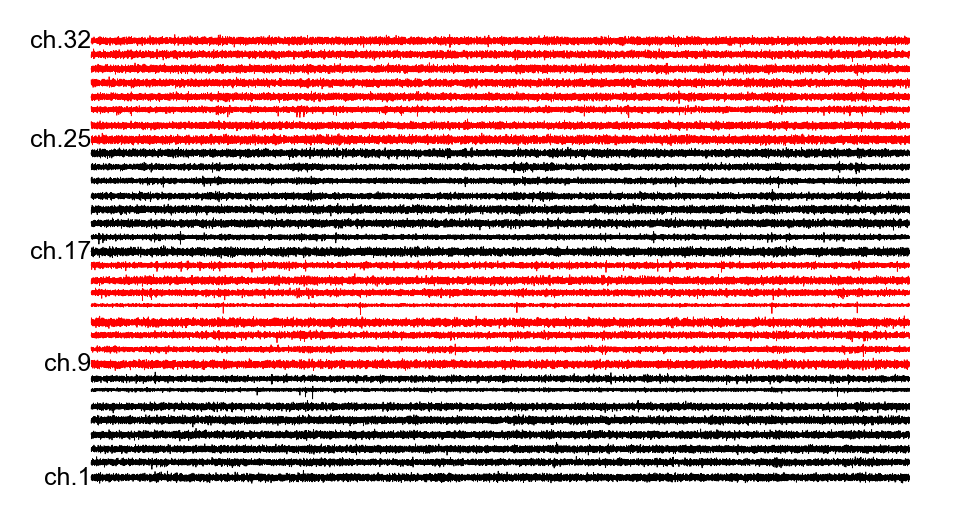

In [46]:
"""
Spike band
eta 2m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'raw_lfp')
default_sample_rate = load_hdf5_to_var(session_hdf_file, 'default_sample_rate')
ref = np.expand_dims(np.mean(lfp_disk_array,axis=1),axis=-1)
lfp_disk_array -= ref
nyquist = 0.5 * default_sample_rate
low = 600 / nyquist
high = 6000 / nyquist
b, a = sci.signal.butter(2, [low, high], btype='band')
for ch in tqdm(range(lfp_disk_array.shape[1])):
    lfp_disk_array[:,ch] = sci.signal.filtfilt(b, a, lfp_disk_array[:,ch], axis=0).astype('float16')


update_hdf_data(session_hdf_file, 'spikeband_lfp', lfp_disk_array)
plot_sample_wave(lfp_disk_array,default_sample_rate)

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

In [128]:
import numpy as np
import matplotlib.pyplot as plt

def proccess_trace_mua(trace, uv_thresh=-35, fs=30000, plot_wind_ms=[-1, 1.5], n_plots=100,ds_factor = 1,to_plot=False):
    thresh_crossing = np.diff(trace <= uv_thresh, prepend=0)
    starts = np.where(thresh_crossing == 1)[0]
    if not to_plot:
        return starts
    else:
        window_tics = np.arange(plot_wind_ms[0]/1000 * fs, plot_wind_ms[1]/1000 * fs,ds_factor)
        plot_indicies = np.expand_dims(starts, -1) + np.expand_dims(window_tics, 0)

        is_bad = np.logical_or(plot_indicies < 0, plot_indicies >= len(trace))
        row_good = np.sum(is_bad, axis=1) == 0
        plot_indicies = plot_indicies[row_good, :]
        plot_time = window_tics / fs * 1000  # Convert to milliseconds
        spike_mat = trace[plot_indicies.astype(int)]
        # Randomly select 100 rows from spike_mat
        if spike_mat.shape[0] > n_plots:
            selected_indices = np.random.choice(spike_mat.shape[0], n_plots, replace=False)
        else:
            selected_indices = np.arange(spike_mat.shape[0])  # Use all if less than 100

        selected_spikes = spike_mat[selected_indices, :]

        fig, ax = plt.subplots(figsize=(1,1))

        for i in range(selected_spikes.shape[0]):
            ax.plot(plot_time, selected_spikes[i, :],color ='k',linewidth=.1,alpha=.5)

        ax.axhline(uv_thresh, color='r',linewidth=0.1)
        ax.set_xlim([plot_wind_ms[0], plot_wind_ms[1]])  # Set x-axis limits to the desired window
        plt.show()
    return starts



In [ ]:
"""
Get Rasters from Spikes
eta 2m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'spikeband_lfp')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
default_sample_rate = load_hdf5_to_var(session_hdf_file, 'default_sample_rate')
raster_ds = list()
for ch in tqdm(range(lfp_disk_array.shape[1])):
    raster_default = proccess_trace_mua(lfp_disk_array[:, ch],uv_thresh=-75)
    raster_ds.append( (raster_default / (default_sample_rate/downsampled_rate)).astype(int))

del(lfp_disk_array)
os.remove(tempfile_name)

lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'downsampled_lfp')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
lfp_disk_array=lfp_disk_array*0.
for ch in tqdm(range(lfp_disk_array.shape[1])):
    lfp_disk_array[raster_ds[ch],ch] = 1.

update_hdf_data(session_hdf_file,  'raster_bool', lfp_disk_array)
plot_sample_wave(lfp_disk_array,default_sample_rate,times=[0,1])

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Loading float16 array shape: (108423552, 32) from HDF5...


In [195]:
import numpy as np
import scipy.signal as sci
from tqdm import tqdm

def compute_firing_rate(lfp_disk_array, downsampled_rate, window_size_sec=0.1):
    """
    Computes the firing rate using a moving mean across a specified window size.

    Parameters:
    - lfp_disk_array: A boolean matrix indicating spike occurrences (True/False).
    - downsampled_rate: The downsample rate in Hz.
    - window_size_sec: The width of the kernel in seconds (default is 0.1 seconds).

    Returns:
    - firing_rate_array: A matrix of firing rates (spikes per second).
    """
    # Convert window size from seconds to the number of samples
    window_size_samples = int(window_size_sec * downsampled_rate)

    # Create a kernel of ones with the length equal to the window size
    kernel = np.ones(window_size_samples)

    # Convolve each channel with the kernel to get spike counts in each window
    for ch in tqdm(range(lfp_disk_array.shape[1])):
        lfp_disk_array[:, ch] = sci.convolve(lfp_disk_array[:, ch], kernel, mode='same')

    # Convert spike counts to firing rates (spikes per second)
    lfp_disk_array = lfp_disk_array / window_size_sec

    return lfp_disk_array

lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'raster_bool')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
lfp_disk_array = compute_firing_rate(lfp_disk_array, downsampled_rate)
update_hdf_data(session_hdf_file,  'mean_firing', lfp_disk_array)


Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.56s/it]


Dataset 'mean_firing' updated.


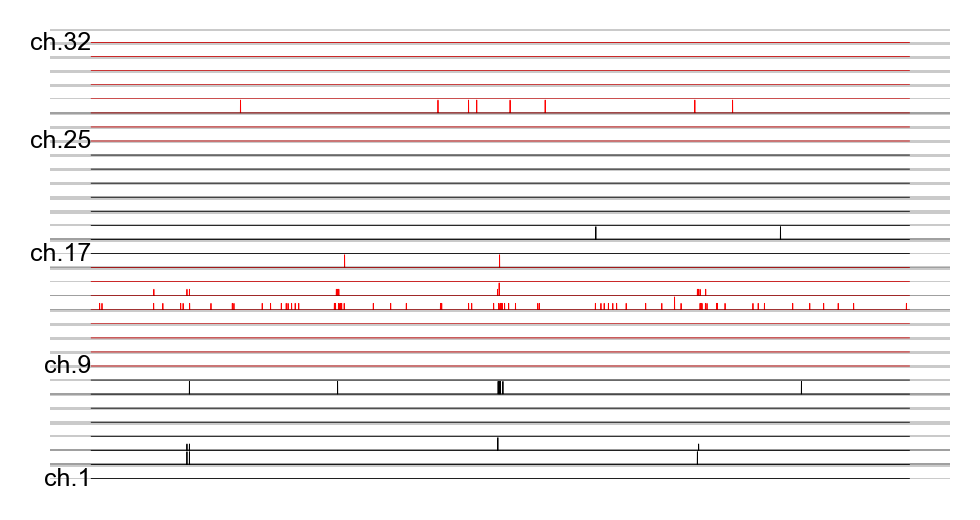

In [196]:
plot_sample_wave(lfp_disk_array,default_sample_rate,times=[0,60],tics=[0,.1])

Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.33it/s]


Dataset 'wideband_lfp' updated.


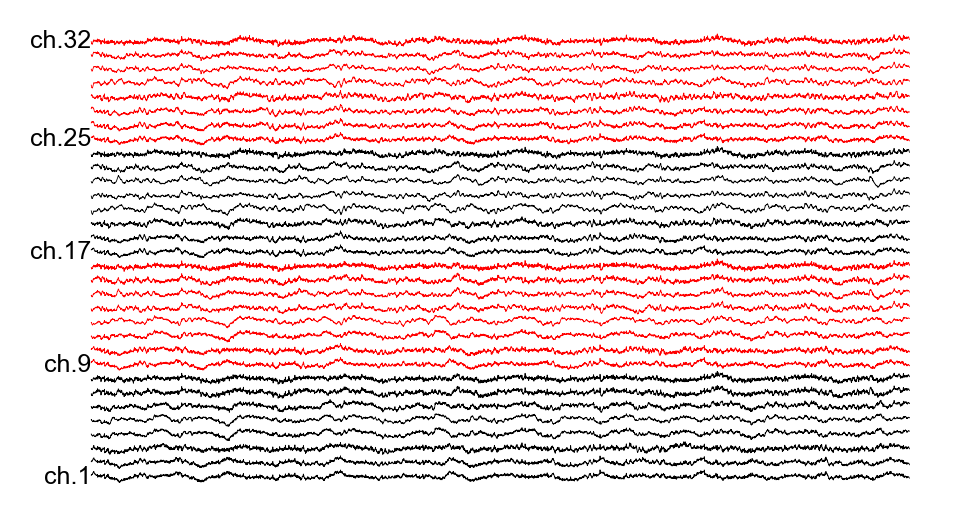

In [14]:
"""
WIDE BAND PASS
eta 2m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'downsampled_lfp')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
nyquist = 0.5 * downsampled_rate
low = 0.1 / nyquist
high = 1000 / nyquist
b, a = sci.signal.butter(2, [low, high], btype='band')
for ch in tqdm(range(lfp_disk_array.shape[1])):
    lfp_disk_array[:,ch] = sci.signal.filtfilt(b, a, lfp_disk_array[:,ch], axis=0).astype('float16')

update_hdf_data(session_hdf_file, 'wideband_lfp', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.
Dataset 'fir_coeff' updated.
Dataset 'passband' updated.
Dataset 'ripple_filtered' updated.


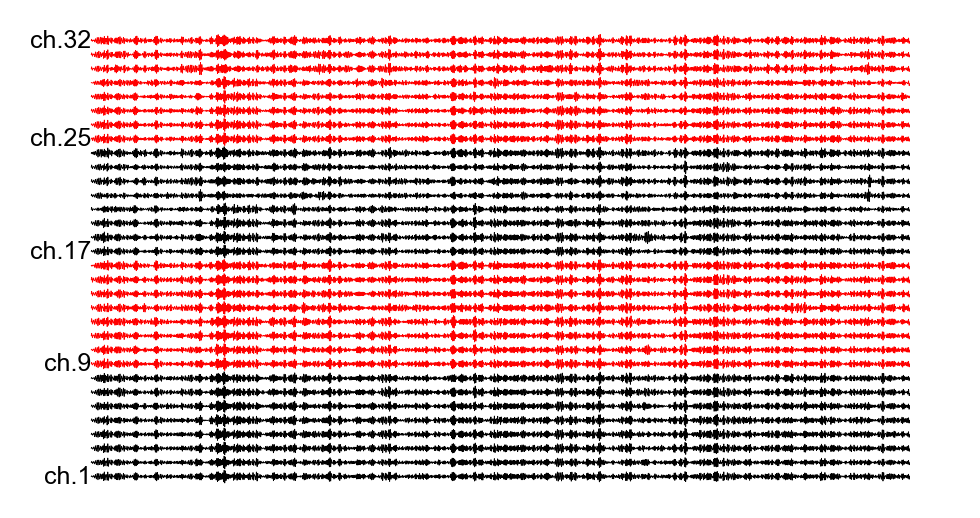

In [15]:
"""
BAND PASS FOR RIPPLES
eta 3m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'wideband_lfp')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')

passband = np.array([142.5, 255.5]) #(150-250 Hz)
width= 25
passband = passband #+ [-(width),width]
num_coefficients = 507
downsampled_rate = 5000
fir_coeff = sci.signal.firwin(num_coefficients, passband,width=width, window='hanning', pass_zero='bandpass', scale=True, fs=float(downsampled_rate))
# mat_contents = scipy.io.loadmat(r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze\YTripplefilter_5khz.mat')
# fir_coeff = mat_contents['ripplefilter'][0][0][0][0]
update_hdf_data(session_hdf_file, 'fir_coeff', fir_coeff)
update_hdf_data(session_hdf_file, 'passband', passband)

''' Apply the FIR filter using filtfilt for zero-phase filtering across all channels '''
lfp_disk_array = sci.signal.filtfilt(fir_coeff, 1.0, lfp_disk_array.astype('float64'), axis=0).astype('float16')
update_hdf_data(session_hdf_file, 'ripple_filtered', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)


'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:57<00:00,  9.31s/it]


Dataset 'hilbert_envelope' updated.


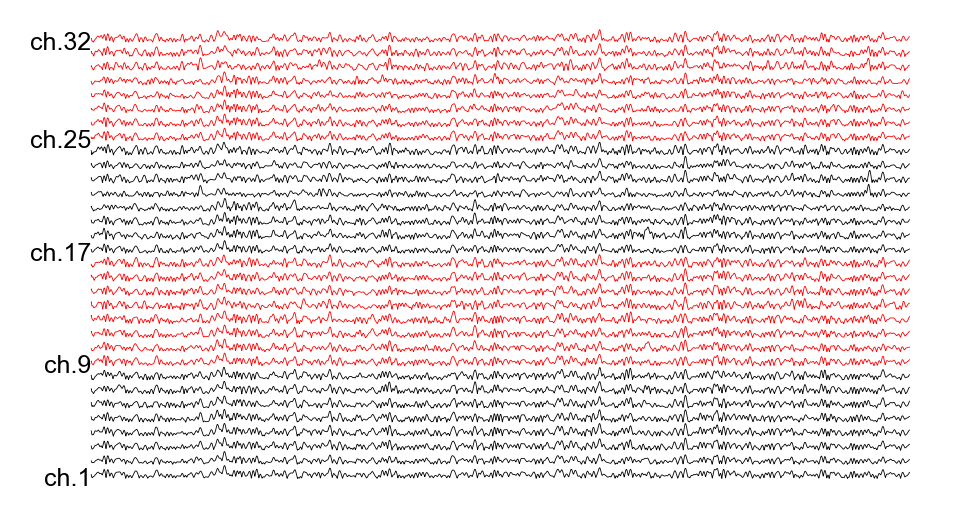

In [16]:
"""
Hilbert Envelope
eta 3m
"""
lfp_disk_array, tempfile_name  = load_hdf5_to_memmap(session_hdf_file, 'ripple_filtered')
downsampled_rate = load_hdf5_to_var(session_hdf_file,'downsampled_rate')
for ch in tqdm(np.arange(lfp_disk_array.shape[1])):
    lfp_disk_array[:,ch] =  abs(sci.signal.hilbert(lfp_disk_array[:,ch])).astype('float16')
update_hdf_data(session_hdf_file, 'hilbert_envelope', lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:44<00:00,  3.26s/it]


Dataset 'smooth_envelope' updated.
Dataset 'smooth_z_envelope' updated.
[18.21426  18.590698 18.442585 18.548223 19.384962 18.568913 18.775303
 18.513119 18.258009 19.117712 18.511364 19.112709 21.185509 19.595915
 18.506395 18.410866 18.189793 19.676447 18.65404  20.004852 22.892733
 21.614214 20.535088 18.402197 18.316666 18.182291 19.579493 19.426388
 19.481256 22.284096 20.160189 17.746174]
[16.881401 17.028328 16.795248 16.810366 16.70571  16.892485 16.962461
 16.921486 16.733814 17.292048 16.780502 16.610296 16.697819 16.834469
 16.715534 16.875467 16.709272 17.496914 16.63962  16.578056 16.855062
 16.945019 16.756441 16.858526 16.559057 16.681839 17.267744 16.951529
 16.55433  16.646564 16.62374  16.777294]
Dataset 'env_means' updated.
Dataset 'env_stds' updated.


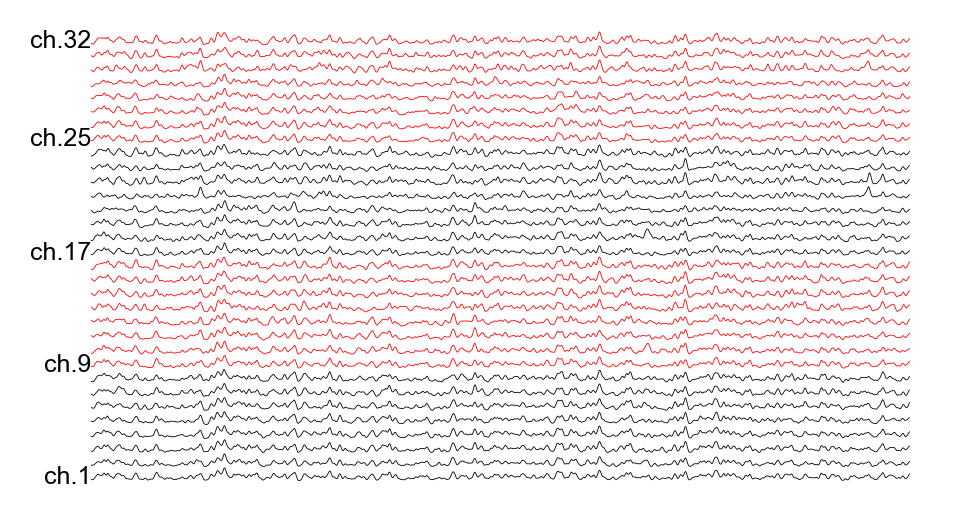

In [17]:
"""
Smoothed
eta 3m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'hilbert_envelope')
downsampled_rate = load_hdf5_to_var(session_hdf_file,'downsampled_rate')
lfp_disk_array =  lfp_disk_array.astype('float32')
gauss_width_ms = 4
sigma = gauss_width_ms/1000*downsampled_rate
filter_width_sigmas = 8
num_channels = lfp_disk_array.shape[1]
for c in tqdm(np.arange(num_channels)):
    lfp_disk_array[:,c] = sci.ndimage.gaussian_filter1d(lfp_disk_array[:,c],
                                                sigma, axis=0, mode='reflect',
                                                truncate=filter_width_sigmas)
update_hdf_data(session_hdf_file, 'smooth_envelope', lfp_disk_array)
means = np.mean(lfp_disk_array,axis=0)
stdevs = np.std(lfp_disk_array,axis=0)
lfp_disk_array -= means
lfp_disk_array /= stdevs
update_hdf_data(session_hdf_file, 'smooth_z_envelope', lfp_disk_array)
print(means)
print(stdevs)

lfp_disk_array =  lfp_disk_array.astype('float32')
# check_valid(lfp_disk_array)

update_hdf_data(session_hdf_file, 'env_means', means)
update_hdf_data(session_hdf_file, 'env_stds', stdevs)
plot_sample_wave(lfp_disk_array,downsampled_rate)


'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Loading float32 array shape: (18070592, 32) from HDF5...
Loading complete.
DataFrames have been saved in the HDF5 file under the 'ripple_dfs' group.


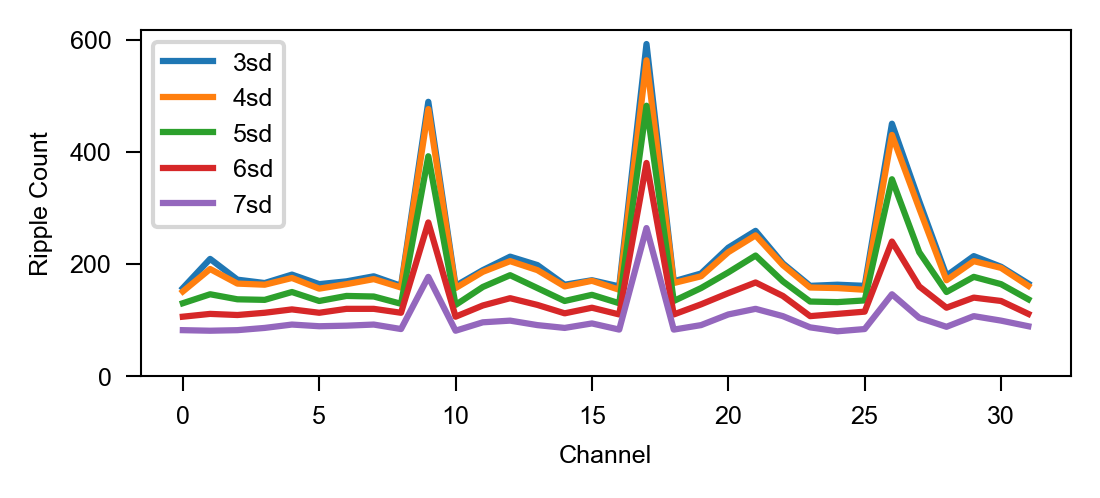

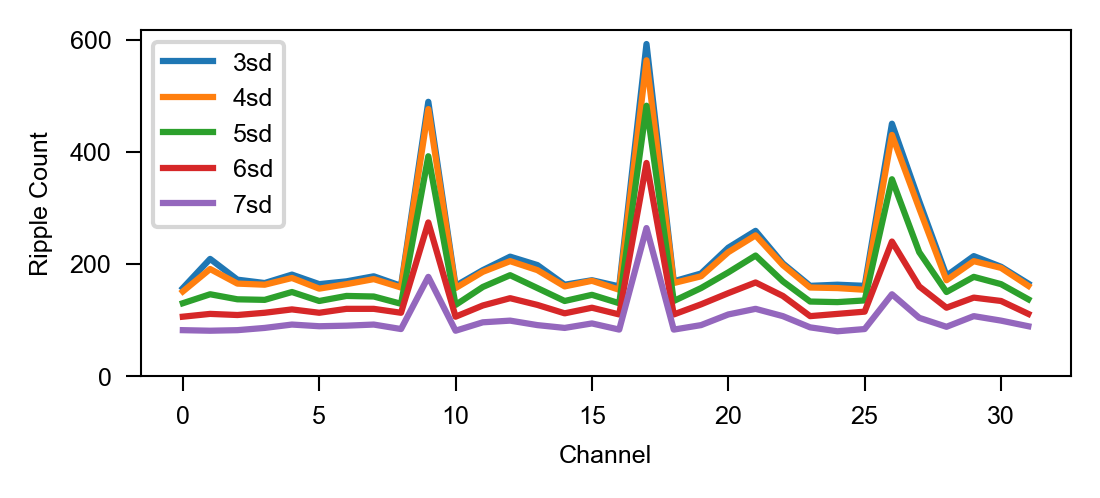

In [18]:
"""
Count Ripples
eta 1m
"""
lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'smooth_z_envelope')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
ripple_df_list = [find_trace_ripples_df_v4(lfp_disk_array[:,ch],downsampled_rate) for ch in np.arange(lfp_disk_array.shape[1])]
plot_rip_counts(ripple_df_list)

save_dataframes_to_hdf5(session_hdf_file, ripple_df_list, group_name='ripple_dfs')
loaded_dataframes = load_dataframes_from_hdf5(session_hdf_file, group_name='ripple_dfs')
plot_rip_counts(loaded_dataframes)

'Clear Ram & Disk'
del(lfp_disk_array)
os.remove(tempfile_name)

Dataset 'velocity' updated.
Dataset 'time' updated.
DataFrames have been saved in the HDF5 file under the 'ripple_df_list_rest' group.


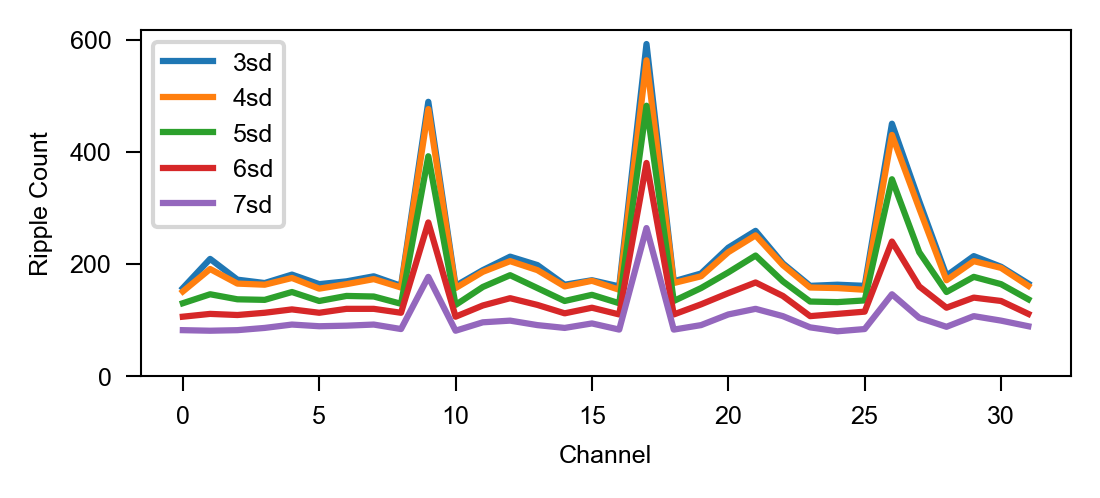

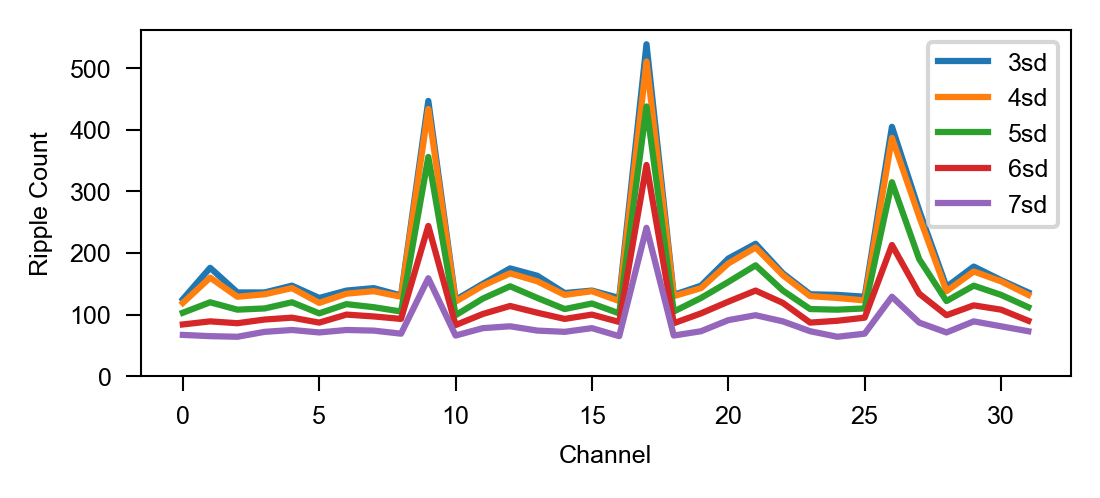

In [19]:
"""
Import Position
"""
import os
import re
import struct
import numpy as np

def extract_position(file_loc,cm_pix=40/535):
    """
    Extracts position data from a binary file.
    Note: videoPositionTracking files are binaries but are not
    labeled as such.

    Parameters:
    file_loc (str): The location of the file to be read.

    Returns:
    numpy.ndarray: An array of position data.
    """
    format_dict = {'uint32': 'I', 'uint16': 'H'}

    with open(file_loc, mode='rb') as file:
        filecontent = file.read()

    header = str(filecontent[:300])
    clockrate_match = re.search(r'clockrate:\s*(\d+)', header)
    clockrate = int(clockrate_match.group(1))
    header = header.split('<End settings>')[0]
    field_section = header.split('Fields: ')[-1]
    fields = re.findall(r'<.*?>', field_section)
    units = [f.split(' ')[-1][:-1] for f in fields]
    field_names = [f.split(' ')[0][1:] for f in fields]
    record_format = ''.join([format_dict[u] for u in units])

    header_len = len(header + '<End settings>') - header.count('\\n') - 1
    record_format = ''.join([format_dict[u] for u in units])
    record_size = struct.calcsize(record_format)
    records = []

    with open(file_loc, 'rb') as file:
        file.seek(header_len)
        while chunk := file.read(record_size):
            if len(chunk) == record_size:
                record = struct.unpack(record_format, chunk)
                records.append(record)

    records = np.stack(records)
    tics = records[:,0]
    tics = tics[0] + np.arange(len(tics))*int(np.median(np.diff(tics))) # regularize jitter
    time = tics /clockrate



    position_data = records[:, 1:]
    x_pos = position_data[:,0] * cm_pix # cm/px
    y_pos = position_data[:,1] * cm_pix # cm/px

    sigma = 15
    x_pos = sci.ndimage.gaussian_filter1d(x_pos,sigma,
                                          mode='reflect',truncate=sigma*4)

    y_pos = sci.ndimage.gaussian_filter1d(y_pos,sigma,
                                          mode='reflect',truncate=sigma*4)

    delta_cm = np.sqrt(np.diff(x_pos)**2 + np.diff(y_pos)**2)
    delta_t = np.diff(time)
    velocity = delta_cm/delta_t
    velocity = np.concatenate([[velocity[0]],velocity])
    velocity[np.logical_not(np.isfinite(velocity))] = np.nan

    return x_pos, y_pos, time, velocity


    # starts,stops = find_starts_stops(velocity,thresh)

    # stops=np.concantenate([0],stops)
    # starts=np.concantenate(starts,[0])

    # gaps = stops

    # frame_rate = int(1/np.mean(np.diff(time)))
    # margin_frames = margin_s*frame_rate
    # print(gap_dur)
    # gap_dur_sec = gap_dur/frame_rate

# movement_filter(velocity,time,thresh=1,margin_s=30)


def movement_detection(velocity,time,thresh=1,min_dur_sec=30):

    not_moving = (velocity<thresh).astype(float)
    starts = np.where(np.diff(not_moving,prepend=velocity[0]>=thresh)==[1])[0]
    stops = np.where(np.diff(not_moving,append=velocity[-1]>=thresh)==[-1])[0]

    streak_dur = time[stops]-time[starts]
    valid_streak = streak_dur>=min_dur_sec

    starts = starts[valid_streak]
    stops = stops[valid_streak]

    # print(valid_streak)
    # fig,ax=plt.subplots(3,1,figsize=(6,3),sharex=True)
    # ax[0].plot(not_moving,linewidth=.5)
    # ax[1].plot(np.diff(not_moving,prepend=not_moving[0]),linewidth=.5)
    # ax[0].scatter(starts,np.ones_like(starts),s=1,color='g')
    # ax[0].scatter(stops,np.zeros_like(stops),s=1,color='k')
    valid_times = pd.DataFrame({'starts_s':time[starts],
                                'stops_s':time[stops],
                                'starts':starts,
                                'stops':stops,
                                })
    return valid_times


"""
Filter Movement Events
"""
def remove_movement_events(rip_df, valid_times):
    """
    Remove movement-related events from a DataFrame based on valid time windows.

    This function trims events from `rip_df` that do not occur within the specified
    valid time windows provided by `valid_times`. Each event in `rip_df` is evaluated
    to determine if its start and stop times fall within a consistent time window.

    Parameters:
    - rip_df (pd.DataFrame): A DataFrame containing events, with at least the following columns:
        - 'starts_s': Start time of each event (in seconds).
        - 'stops_s': Stop time of each event (in seconds).
    - valid_times (pd.DataFrame): A DataFrame containing valid time windows, with at least the following columns:
        - 'starts_s': Start time of each valid window (in seconds).
        - 'stops_s': Stop time of each valid window (in seconds).

    Returns:
    - rip_df_trim (pd.DataFrame): A trimmed version of `rip_df` containing only the events that fall
      within a valid time window, with an additional column 'window' indicating the index of the
      valid window the event belongs to.
    """
    rip_df_trim = rip_df.copy()  # Make a copy of the input DataFrame to avoid modifying the original
    rip_df_trim['window'] = -1  # Initialize a new column 'window' to track valid window indices

    for rip in rip_df.index:
        # Check if the event start time falls within any valid window
        start_after_window_start = rip_df_trim.loc[rip, 'starts_s'] >= valid_times['starts_s'].values
        start_before_window_stop = rip_df_trim.loc[rip, 'starts_s'] <= valid_times['stops_s'].values
        start_window = np.where(np.logical_and(start_after_window_start, start_before_window_stop))[0]

        # If no valid start window is found, set to NaN
        if len(start_window) == 0:
            start_window = np.nan

        # Check if the event stop time falls within any valid window
        stop_after_window_start = rip_df_trim.loc[rip, 'stops_s'] >= valid_times['starts_s'].values
        stop_before_window_stop = rip_df_trim.loc[rip, 'stops_s'] <= valid_times['stops_s'].values
        stop_window = np.where(np.logical_and(stop_after_window_start, stop_before_window_stop))[0]

        # If no valid stop window is found, set to NaN
        if len(stop_window) == 0:
            stop_window = np.nan

        # If the start and stop times fall within the same valid window, update the 'window' column
        if start_window == stop_window:
            rip_df_trim.at[rip, 'window'] = start_window


    # Remove events that do not fall within any valid window
    # print( f'Removing {len(rip_df_trim) - np.sum(rip_df_trim['window'] >= 0)}')
    rip_df_trim = rip_df_trim[rip_df_trim['window'] >= 0]


    # Reset the index of the trimmed DataFrame for clean output
    rip_df_trim = rip_df_trim.reset_index(drop=True)


    return rip_df_trim



file_loc = r"\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ZL04_6201\ZL04_6201.1.videoPositionTracking"
x_pos, y_pos, time, velocity = extract_position(file_loc)
valid_times = movement_detection(velocity,time)
update_hdf_data(session_hdf_file, 'velocity', velocity)
update_hdf_data(session_hdf_file, 'time', time)


ripple_df_list = load_dataframes_from_hdf5(session_hdf_file, group_name='ripple_dfs')
plot_rip_counts(ripple_df_list)
ripple_df_list_rest = [remove_movement_events(rip_df,valid_times) for rip_df in ripple_df_list]

save_dataframes_to_hdf5(session_hdf_file, ripple_df_list_rest, group_name='ripple_df_list_rest')
ripple_df_list_rest = load_dataframes_from_hdf5(session_hdf_file, group_name='ripple_df_list_rest')
plot_rip_counts(ripple_df_list_rest)


In [20]:
ripple_df_list[0]

,starts,stops,starts_s,stops_s,max_tic,thresh_cross,ripple_sd_max,duration_ms
0,18881.0,20803.0,3.7762,4.1606,20441.0,19175.0,6.829159,384.4
1,20852.0,26436.0,4.1704,5.2872,25107.0,20898.0,10.339250,1116.8
2,26490.0,29134.0,5.2980,5.8268,27876.0,26628.0,11.691851,528.8
3,29491.0,31832.0,5.8982,6.3664,30741.0,29862.0,12.515140,468.2
4,132724.0,134525.0,26.5448,26.9050,134330.0,132964.0,6.211907,360.2
...,...,...,...,...,...,...,...,...
152,17704994.0,17705851.0,3540.9988,3541.1702,17705469.0,17705066.0,11.553072,171.4
153,17979998.0,17994899.0,3595.9996,3598.9798,17982149.0,17980062.0,17.992466,2980.2
154,17995054.0,17999557.0,3599.0108,3599.9114,17997069.0,17995104.0,6.447060,900.6
155,18014634.0,18030327.0,3602.9268,3606.0654,18022113.0,18014922.0,31.809906,3138.6


In [ ]:
def remove_multi_channel_events(ripple_df_list, thresh=10):
    """
    Remove events from multiple DataFrames in a list based on the number of channels involved.

    This function removes events that occur on more than a specified number of channels simultaneously.
    It first identifies the overlapping events across channels and then removes these events from each
    DataFrame in `ripple_df_list`.

    Parameters:
    - ripple_df_list (list of pd.DataFrame): A list of DataFrames where each DataFrame represents events
      for a different channel. Each DataFrame must contain:
        - 'starts': The start times of events (in samples).
        - 'stops': The stop times of events (in samples).
    - thresh (int, optional): The threshold number of channels that must be involved in an event for it
      to be removed. Defaults to 10.

    Returns:
    - ripple_df_list (list of pd.DataFrame): The list of DataFrames with the multi-channel events removed.
    """
    # Find the latest stop time across all channels to determine the time span for analysis
    last_stop = np.max([df['stops'].values[-1] for df in ripple_df_list]).astype(int)

    # Initialize an array to store event IDs for each time point across all channels
    rip_ids = np.ones([len(ripple_df_list), last_stop],dtype='float16') * np.nan

    # Fill the rip_ids array with event IDs for each time point in each channel
    for ch, rip_df in enumerate(ripple_df_list):
        for rip in rip_df.index:
            start = rip_df.loc[rip, 'starts'].astype(int)
            stop = rip_df.loc[rip, 'stops'].astype(int)
            if rip_df.loc[rip,'ripple_sd_max'] >=3:
                rip_ids[ch, start:stop] = rip

    # Calculate the number of channels involved at each time point
    syncros = np.nansum(np.logical_not(np.isnan(rip_ids)), axis=0)
    # Identify time points where the number of involved channels exceeds the threshold
    syncro_check = syncros > thresh

    # Plot the synchronization check for visualization (optional)
    fig, ax = plt.subplots(1, 1, figsize=(6, 1), sharex=True)
    ax.plot(syncro_check, linewidth=.5)
    for ch in np.arange(rip_ids.shape[0]):
        rip_i = np.where(np.logical_not(np.isnan(rip_ids[ch,:])))[0]
        ax.scatter(rip_i,np.ones_like(rip_i) * ch/32,s=1,marker='1')


    # Extract the IDs of events to be removed based on the synchronization check
    to_remove = rip_ids[:, syncro_check]

    # Iterate through each DataFrame and remove the identified multi-channel events
    for i, df in enumerate(ripple_df_list):
        indices_to_drop = list(set(to_remove[i, :]))
        indices_to_drop = [ind.astype(int) for ind in indices_to_drop if not np.isnan(ind)]
        # print(indices_to_drop)
        ripple_df_list[i] = df.drop(indices_to_drop)

    return ripple_df_list


ripple_df_list_rest = load_dataframes_from_hdf5(session_hdf_file, group_name='ripple_df_list_rest')
ripple_df_list_cut = remove_multi_channel_events(ripple_df_list_rest)
save_dataframes_to_hdf5(session_hdf_file, ripple_df_list_cut, group_name='ripple_df_list_cut')
plot_rip_counts(ripple_df_list_cut)


In [22]:
# from IPython.display import display, clear_output
# import time
# # lfp_disk_array = load_hdf5_to_memmap(session_hdf_file, 'smooth_z_envelope')
# # ripple_df_list[9].to_csv('Channel_9_Rips.csv')

# def flip_through_rips(rip_df,env_data,rip_data,sample_rate):
#     fig,ax=plt.subplots(figsize=(4,1))
#     ax.grid('on')
#     ax.set_ylim(-1,6)
#     ax.axhline(3,color='r')
#     shuffled_indices = rip_df.sample(frac=1).index
#     for rip in shuffled_indices:
#         ripple_stats = rip_df.loc[rip].to_dict()

#         ax.clear()
#         ax.grid(True)
#         ax.set_ylim(-12, 12)
#         ax.axhline(3, color='r')
#         # ax.set_xlim(-20,700)

#         neg_window = -350

#         begin = int(ripple_stats['starts'])+neg_window
#         end = int(ripple_stats['stops'])+650
#         trace_rip = (rip_data[begin:end]/25)
#         # trace_rip = abs(trace_rip)
#         time_points = (np.arange(begin,end)-begin)/sample_rate *1000
#         ax.plot(time_points, trace_rip,'k',linewidth=1)


#         begin = int(ripple_stats['starts'])
#         end = int(ripple_stats['stops'])
#         trace_env = env_data[begin:end]
#         time_points = ((np.arange(begin,end)-begin) - neg_window)/sample_rate * 1000
#         ax.plot(time_points, trace_env,'m',linewidth=1)
#         ax.set_title(np.max(trace_env))

#         begin = int(ripple_stats['starts'])+neg_window
#         end = int(ripple_stats['stops'])+650
#         trace_env = env_data[begin:end]
#         time_points = ((np.arange(begin,end)-begin))/sample_rate * 1000
#         ax.plot(time_points, trace_env,'m',linewidth=.3)
#         ax.set_title(np.max(trace_env))

#         display(fig)
#         time.sleep(1.5)
#         clear_output(wait=True)

# flip_through_rips(ripple_df_list[9],env_data,rip_data,downsampled_rate)

In [23]:
def spectral_analysis(lfp_disk_array_wideband,downsampled_rate,fpass = [.1,350],time_per_seg_ms=50,ratio_overlap=0.5):
    nperseg = int(time_per_seg_ms/1000 * downsampled_rate)
    noverlap = nperseg // (1/ratio_overlap)
    freqs, spectro_time, spectro_data = sci.signal.spectrogram(lfp_disk_array_wideband,
                                                               downsampled_rate,
                                                               nperseg=nperseg,
                                                               noverlap=noverlap,
                                                               mode='psd',
                                                               axis=0)
    print(freqs)
    # spectro_data = spectro_data

    "trim frequency"
    fpass_bool = np.logical_and(freqs>fpass[0] , freqs<fpass[1])
    freqs = freqs[fpass_bool]
    spectro_data = spectro_data[fpass_bool,:,:]

    "z-score"
    mean_over_t = np.mean(spectro_data,axis=2)
    sd_over_t = np.std(spectro_data,axis=2)
    spectro_data = (spectro_data.transpose([2,0,1]) - mean_over_t)/sd_over_t

    return freqs, spectro_time, spectro_data

lfp_disk_array, tempfile_name = load_hdf5_to_memmap(session_hdf_file, 'wideband_lfp')
downsampled_rate = load_hdf5_to_var(session_hdf_file, 'downsampled_rate')
freqs, spectro_time, spectro_data = spectral_analysis(lfp_disk_array, downsampled_rate)

update_hdf_data(session_hdf_file, 'spectro_data', spectro_data)
update_hdf_data(session_hdf_file, 'spectro_time', spectro_time)
update_hdf_data(session_hdf_file, 'freqs', freqs)

Loading float16 array shape: (18070592, 32) from HDF5...
Loading complete.
[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.
  480.  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.
  720.  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.
  960.  980. 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180.
 1200. 1220. 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380. 1400. 1420.
 1440. 1460. 1480. 1500. 1520. 1540. 1560. 1580. 1600. 1620. 1640. 1660.
 1680. 1700. 1720. 1740. 1760. 1780. 1800. 1820. 1840. 1860. 1880. 1900.
 1920. 1940. 1960. 1980. 2000. 2020. 2040. 2060. 2080. 2100. 2120. 2140.
 2160. 2180. 2200. 2220. 2240. 2260. 2280. 2300. 2320. 2340. 2360. 2380.
 2400. 2420. 2440. 2460. 2480. 2500.]
Dataset 'spectro_data' updated.
Dataset 'spectro_time' updated.
Dataset 'freqs' updated.


In [24]:
# lead_spect = spectro_data[:,:,leader_ch]
# lead_spect.shape

In [25]:
"""
Triggered Spectrogram
"""

def fuzzy_time_match(query_time, target_time):
    delta_t = target_time[:,np.newaxis] - query_time
    match_index = np.argmin(abs(delta_t),axis=0)
    match_time = target_time[match_index]
    return match_index, match_time

'Get Time Triggers'
# leader_ch = np.argmax([np.sum(df['ripple_sd_max']>7) for df in ripple_df_list])
leader_ch = 9

leader_ch_df = ripple_df_list[leader_ch].copy()
leader_ch_df = leader_ch_df[leader_ch_df['ripple_sd_max']>5]

ripple_trigs = (leader_ch_df['thresh_cross']).values
ripple_trigs_sec = ripple_trigs/downsampled_rate
match_index, match_time = fuzzy_time_match(ripple_trigs_sec,spectro_time)


In [26]:
trig_windo_lens = 0.400
spectro_FS = 1/(spectro_time[1]-spectro_time[0])
relative_spect_window = np.arange(-trig_windo_lens*spectro_FS,trig_windo_lens*spectro_FS+1/spectro_FS)
relative_spect_window_sec = relative_spect_window/spectro_FS
trig_index_mat = (match_index[:,np.newaxis] + relative_spect_window).astype('int')
bad_trig = np.logical_or(trig_index_mat<0,trig_index_mat>=spectro_data.shape[0])
bad_trig = np.sum(bad_trig,axis=1)>0
trig_index_mat = trig_index_mat[~bad_trig,:]
triggered_spectro_data = spectro_data[trig_index_mat]
mean_triggered = np.mean(triggered_spectro_data,axis=0)



# mean_triggered.shape

In [27]:
spectro_FS

40.0

In [ ]:
mean_triggered.shape

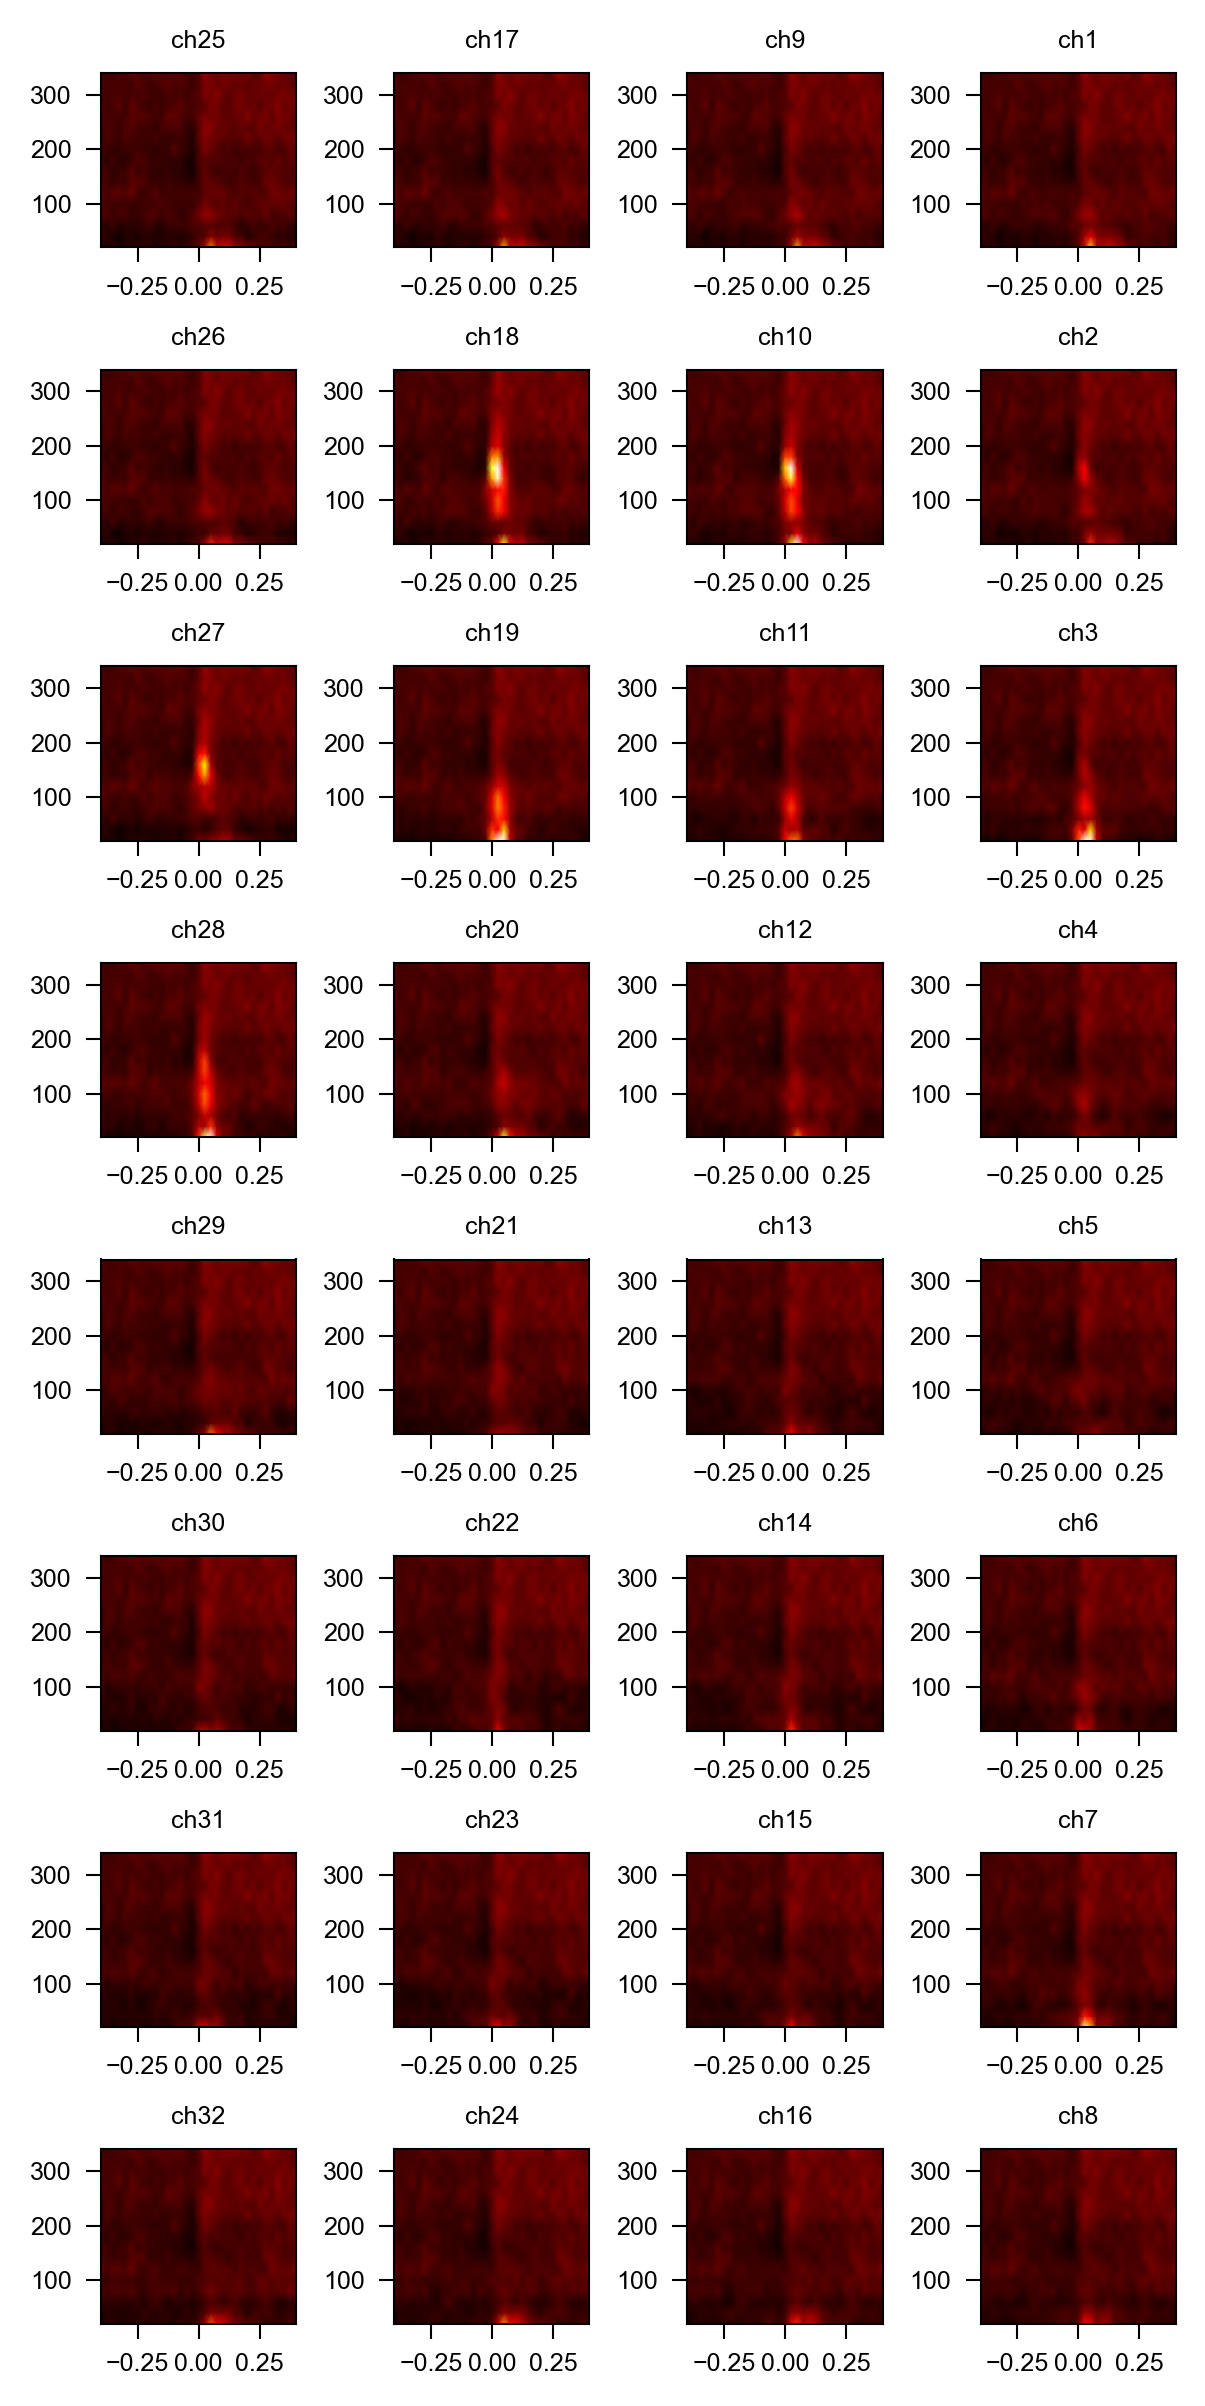

In [151]:
fig,ax =plt.subplots(8,4,figsize=(4,8),dpi=300)
num_channels = mean_triggered.shape[-1]
for ch in range(num_channels):
    ax[axm(ch)].set_title(f'ch{ch+1}')
    ax[axm(ch)].pcolormesh(relative_spect_window_sec, freqs, mean_triggered[:,:,ch].T, cmap='hot',shading='gouraud',vmin=0,vmax=4)
plt.tight_layout()